# Step 0: Initial set up

Note this is for the type 1 simulation I did - which is bulge and halo in galaxy 2 and bulge halo and disk in galaxy 1

In [1]:
import os
import sys
import pandas as pd
import numpy as np

#Find the current directory
current_dir = os.getcwd()

#Load extra_functions.py in the current_dir
sys.path.append(current_dir)

import extra_functions as ef

#Write the filepath to the jobs_back folder
jobs_back = os.path.join(current_dir, 'jobs_back')

#Create a list of all the folders in the jobs_back folder
folders = os.listdir(jobs_back)

print(folders)
#List the particle types to gather data for 
# ###NOTE THIS NEEDS TO BE ADDED TO/CHANGED DEPENDING ON THE DATA YOU HAVE
particle_types = ['0', '1', '2', '3', '4']

#Note if you change these you will also have to change the timesteps (in the top spot) in extra_functions.py
start_timestep = 4
end_timestep = 6

#Create a dataframe for the paramaters
paramaters = pd.DataFrame(columns = ['job_number', ' particles type'])
paramaters_control = pd.DataFrame(columns = ['job_number', ' particles type'])

#Turn off warnings in the terminal

import warnings
warnings.filterwarnings('ignore')


['1069', '2085', '1056', '2071', '2049', '2076', '1051', '2082', '1058', '1093', '2040', '1067', 'Control2', '2078', '1060', '2047', '1094', '1034', '1206', '2013', '2014', '1201', '1033', '2022', '1005', '1208', '1002', '1230', '2025', '2079', 'Control3', '2046', '1095', '1061', '1059', '1066', '1092', '2041', '2048', '1050', '2083', '2077', '1068', '2070', '2084', '1057', '2024', '1231', '1003', '1004', '2023', '1209', '1032', '1200', '2015', '2012', '1207', '1035', '1178', '1147', '1140', '1149', '1182', '1176', '.DS_Store', '1171', '1185', '1125', '2102', '2105', '1122', '1114', '1113', '1184', '1170', '1148', '1177', '1183', '1141', '1179', '1146', '1112', '1115', '1123', '2104', '2103', '1124', '1139', '1106', '2119', '1101', '1108', '1137', '2110', '2117', '1130', '1190', '1164', '1163', '1197', '1155', '1152', '1199', '1131', '2116', '1109', '2111', '1136', '2118', '1100', '1138', '1107', '2120', '1153', '1198', '1154', '1196', '1162', '1165', '1191', '1028', '2030', '1017', '1

In [ ]:
#pull in the folder 1000 job into data and clean it and use in testing
df = ef.adjust_data(ef.read_data(1036))
df = df[df[' particles type'] != '5']
df = ef.remove_first_timestep(ef.add_vector_length(df))


# Step 1: Load the control
Note: The control are 3 simulations I ran to compare to the interractions - everything but the velocity and initial position is the same (velocity is 000 and the initial position is far away from galaxy 1 to avoid interractions here).
In the gi foler (same place this is) you need to have a folder called 'jobs_back' which has all the folders there. The controls need to be named 'Control1' 'Control2' etc. if you use controls. This function below will average the simulations inputted.

In [3]:
#Write a loop that will loop over the folders and build up a df_control from the average of 3 simulations

from collections import defaultdict


#These are the functions to analyse
functions = [ef.calculate_eccentricity, ef.calculate_relative_density_table, ef.calculate_fwhm_2D, ef.calculate_fwhm_3D, ef.calculate_fwhm_method_1, ef.calculate_half_mass_radius, ef.calculate_scale_length, ef.calculate_surface_brightness, ef.calculate_metrics]
#functions = [ef.calculate_average_relative_density]

def get_control(start_timestep, end_timestep, particle_types, folders, functions):
    con_raw = pd.DataFrame(columns = ['job_number', ' particles type','timestep_val'])
    con_summary = pd.DataFrame(columns = ['job_number', ' particles type','timestep_val'])
    for folder in folders:
        #If the word 'Control' is in the name of the folder, then we want to analyse it
        if 'Control' in folder:
            # Need to clean the data!!!
            df = ef.adjust_data(ef.read_data(folder))
            df = df[df[' particles type'] != '5']
            df = ef.remove_first_timestep(ef.add_vector_length(df))

            #loop over the functions to pull the data
            for func in functions:
                control_summary_temp, control_raw_temp = ef.analyse_function_range(func, df, particle_types, start_timestep, end_timestep, folder)
                #drop 'folder' column
                control_summary_temp = control_summary_temp.drop(['folder'], axis = 1)
                control_raw_temp = control_raw_temp.drop(['folder'], axis = 1)
                # Append the new data to con_summary an#d con_raw
                con_summary = con_summary.merge(control_summary_temp, on=[' particles type', 'timestep_val'], how='outer')
                con_raw = con_raw.merge(control_raw_temp, on=[' particles type', 'timestep_val'], how='outer')  
        else:
            continue
    # Add in the job_number column as 'Control'
    con_raw['job_number'] = 'Control'
    con_summary['job_number'] = 'Control'

    # Calculate the averages for columns with the same suffix
    grouped_cols = defaultdict(list)
    for col in con_summary.columns:
        if 'Control' in col:
            attribute = col.split('Control')[1][1:] # Split on 'Control' and remove the first character (number) 
            grouped_cols[attribute].append(col)
            
    for attribute, cols in grouped_cols.items():
        if len(cols) > 1: # Only compute mean if there is more than one column to average
            con_summary['Control'+attribute] = con_summary[cols].mean(axis=1)
            con_raw['Control'+attribute] = con_raw[cols].mean(axis=1)
            con_summary.drop(cols, axis=1, inplace=True)
            con_raw.drop(cols, axis=1, inplace=True)

    return con_summary, con_raw

#Run the function to add new data from get_control to the paramaters_control df - dont override the paramaters_control df
con_summary, con_raw = get_control(start_timestep, end_timestep, particle_types, folders, functions)

#Save the two dataframes to excel files which can be referenced later on - make the excel file have a timestamp and place in a folder 'data'
import datetime
now = datetime.datetime.now()
now = now.strftime("%Y-%m-%d_%H-%M-%S")
#create the data folder if it isnt there
if not os.path.exists('data'):
    os.makedirs('data')
    
con_summary.to_excel('data/control_summary.xlsx')
con_raw.to_excel('data/control_raw.xlsx')




/Users/a/Downloads/ast80011-main/gi/batchrunner/jobs_back/Control2/output/Galaxy Interaction/_output_ascii.csv.gz
/Users/a/Downloads/ast80011-main/gi/batchrunner/jobs_back/Control3/output/Galaxy Interaction/_output_ascii.csv.gz
/Users/a/Downloads/ast80011-main/gi/batchrunner/jobs_back/Control1/output/Galaxy Interaction/_output_ascii.csv.gz


# Step 2: Processing the main data

This is the main section which will calculate the whole array here of the data - if you have a lot of simulations it can take a long time so break it down if you need by limiting the 'folders'.

Note not everything will properly analyse - the fwhm for example requires there to be a shape it can estimate the gausian over which means if it is compleatly destroyed or spread out in the event it will not work.

The structure should be all the folders in 'jobs_back'. In this there is code so only if the folder name starts with a 1 it will run - this can of course be changed.

In [4]:
#If there is a lot of data this will take hours to run depending on the computer

import os
import datetime
import traceback
# Write a loop that will loop over the folders and build up df_control from the average of 3 simulations

# These are the functions to analyze
functions = [ef.calculate_eccentricity, ef.calculate_relative_density_table, ef.calculate_fwhm_2D, ef.calculate_fwhm_3D, ef.calculate_fwhm_method_1, ef.calculate_half_mass_radius, ef.calculate_scale_length, ef.calculate_surface_brightness, ef.calculate_metrics]

# Snip the folders variable to 5
#folders = folders[:5]

# Initialize an Excel file to write the data to
import datetime
now = datetime.datetime.now()
now = now.strftime("%Y-%m-%d_%H-%M-%S")
# Create the data folder if it doesn't exist
if not os.path.exists('data'):
    os.makedirs('data')

def get_data(start_timestep, end_timestep, particle_types, folders, functions):
    processed_job_numbers = set()
    # read in the excel file 'data_summary' if it exists
    if os.path.exists('data/data_summary.csv'):
        data_summary = pd.read_csv('data/data_summary.csv')
        #add the data_summary column 'folder' to the processed_job_numbers set
        processed_job_numbers = set(data_summary['folder'])
        #else continue as normal
    else:

        pass
    error_folders = []
    for folder in folders:
        try:
            # If the folder name starts with a 1, we want to analyze it ###### CHANGE THIS IF YOU NEED#####
            if folder[0] == '1':
                job_number = folder.split('_')[0]  # Extract job number from folder name

                # Check if job number already exists in the processed job numbers set
                if job_number in processed_job_numbers:
                    continue  # Skip this folder
                else:
                    # Need to clean the data!!!
                    df = ef.adjust_data(ef.read_data(folder))
                    df = df[df[' particles type'] != '5']
                    df = ef.remove_first_timestep(ef.add_vector_length(df))

                    # Initialize the dataframes
                    data_raw = pd.DataFrame(columns=[' particles type', 'timestep_val'])
                    data_summary = pd.DataFrame(columns=[' particles type', 'timestep_val'])

                    # Loop over the functions to pull the data
                    for func in functions:
                        data_summary_temp, data_raw_temp = ef.analyse_function_range(func, df, particle_types, start_timestep, end_timestep, folder)
                        # Append the new data to data_summary and data_raw
                        data_summary = data_summary.merge(data_summary_temp, on=[' particles type', 'timestep_val'], how='outer')
                        data_raw = data_raw.merge(data_raw_temp, on=[' particles type', 'timestep_val'], how='outer')

                    #Remove all folder_x and all folder_y columns
                    data_summary = data_summary.drop(columns=['folder_y'])
                    data_summary = data_summary.drop(columns=['folder_x'])
                    data_raw = data_raw.drop(columns=['folder_y'])
                    data_raw = data_raw.drop(columns=['folder_x'])

                    #Remove the job number from the column headers
                    data_summary.columns = [col.replace(job_number+'_', '') for col in data_summary.columns]

                    # Write data_summary to the CSV file
                    with open(f'data/data_summary.csv', 'a') as f_summary:
                        data_summary.to_csv(f_summary, header=f_summary.tell() == 0, index=False)

                    # Write data_raw to the CSV file
                    with open(f'data/data_raw.csv', 'a') as f_raw:
                        data_raw.to_csv(f_raw, header=f_raw.tell() == 0, index=False)

                    # Update the processed job numbers set
                    processed_job_numbers.add(job_number)
        except Exception as e:
            error_folders.append(folder)
            print(f"Error occurred in folder: {folder}")
            print(f"Error message: {str(e)}")
            print("Traceback:")
            traceback.print_exc()  # This will print the traceback

    # Print the error folders
    print("Folders with errors:")
    print(error_folders)

# Create the data folder if it doesn't exist
if not os.path.exists('data'):
    os.makedirs('data')

# Get the current timestamp
now = datetime.datetime.now()
now = now.strftime("%Y-%m-%d_%H-%M-%S")

# Run the function to add new data from get_data to the CSV files
get_data(start_timestep, end_timestep, particle_types, folders, functions)


/Users/a/Downloads/ast80011-main/gi/batchrunner/jobs_back/1069/output/Galaxy Interaction/_output_ascii.csv.gz
Error occurred for particle type: 4, folder: 1069, function: calculate_fwhm_2D
Error message: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Error occurred for particle type: 4, folder: 1069, function: calculate_fwhm_3D
Error message: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
/Users/a/Downloads/ast80011-main/gi/batchrunner/jobs_back/1056/output/Galaxy Interaction/_output_ascii.csv.gz
Error occurred for particle type: 3, folder: 1056, function: calculate_fwhm_2D
Error message: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Error occurred for particle type: 4, folder: 1056, function: calculate_fwhm_2D
Error message: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Error occurred for particle type: 3, folder: 1056, function: calcula

# Step 3: Normalise the data

Analyse and clean some of this data and compare to the control

In [2]:
#Lets read in the summary file for the control and the data
data_summary = pd.read_csv('data/data_summary.csv')
con_summary = pd.read_excel('data/control_summary.xlsx')


In [3]:
#Print the column headers of each
#print(data_summary.columns)
#print(con_summary.columns)

#Cleaning the columns - note this will vary and have to be varied depending on the data set

#Remove 1069 from column headers of data_summary
data_summary.columns = [col.replace('1069', '') for col in data_summary.columns]
#Remove  'Control' from headers of con_summary
con_summary.columns = [col.replace('Control', '') for col in con_summary.columns]

#Drop 'timestep_val' from both
data_summary = data_summary.drop(columns=['timestep_val'])
con_summary = con_summary.drop(columns=['timestep_val'])

#Remove any leading _'s from con_summary - ONLY LEADING - not all
con_summary.columns = [col.lstrip('_') for col in con_summary.columns]

In [4]:
#Check the column headers of each
#print(data_summary.columns)
#print(con_summary.columns)

In [5]:
# Drop 'Unnamed: 0' and 'job_number' from control dataframe
#con_summary.drop(columns=['Unnamed: 0', 'job_number'], inplace=True)

# Merge the con_summary onto the data_summary - data_summary has many more rows due to having multiple folder types (different simulations). I want to keep all of those and repeat con_summary. incolude suffixes _data and _control
merged = data_summary.merge(con_summary, on=[' particles type'], how='left', suffixes=('_data', '_control'))

# Create new dataframe for normalized data
norm_data = merged.copy()

#bring 'folder' and ' particles type' to the front
cols = list(norm_data.columns)
cols.insert(0, cols.pop(cols.index(' particles type')))
cols.insert(0, cols.pop(cols.index('folder')))
norm_data = norm_data.loc[:, cols]

# Loop through columns in merged dataframe
for col in merged.columns:
    # Check if column ends with '_data'
    if col.endswith('_data'):
        # Find corresponding control column
        control_col = col.replace('_data', '_control')
        # Check if corresponding control column exists
        if control_col in merged.columns:
            # Normalize data by dividing data column by corresponding control column
            norm_data[col.replace('_data', '_norm')] = merged[col] / merged[control_col]

In [6]:
print(norm_data.columns)


Index(['folder', ' particles type', 'calculate_eccentricity_data',
       'calculate_relative_density_table_data', 'calculate_fwhm_2D_data',
       'calculate_fwhm_3D_data', 'calculate_fwhm_method_1_data',
       'calculate_half_mass_radius_data', 'calculate_scale_length_data',
       'calculate_surface_brightness_data', 'position_std_dev_data',
       'mean_velocity_data', 'velocity_std_dev_data', 'Unnamed: 0',
       'job_number', 'calculate_eccentricity_control',
       'calculate_relative_density_table_control', 'calculate_fwhm_2D_control',
       'calculate_fwhm_3D_control', 'calculate_fwhm_method_1_control',
       'calculate_half_mass_radius_control', 'calculate_scale_length_control',
       'calculate_surface_brightness_control', 'position_std_dev_control',
       'mean_velocity_control', 'velocity_std_dev_control',
       'calculate_eccentricity_norm', 'calculate_relative_density_table_norm',
       'calculate_fwhm_2D_norm', 'calculate_fwhm_3D_norm',
       'calculate_fwhm_met

In [7]:
#Bring in the rest of the simulation data so we can compare
import os
import json
import pandas as pd

# create an empty dataframe to store the initial_params
initial_params = pd.DataFrame(columns=['folder', 'vx', 'vy', 'vz'])

#filter 'folders' so we only pick up those which start with '1'
folders_run = [f for f in folders if f.startswith('1')]

# loop over each subfolder
for folder in folders_run:
    subfolder = os.path.join(jobs_back, str(folder))
    # read the merge.json file for the velocity_galaxy_2 parameters
    merge_file = os.path.join(subfolder, 'merge.json')
    with open(merge_file, 'r') as f:
        data = json.load(f)
        vx = data['velocity_galaxy_2']['vx']
        vy = data['velocity_galaxy_2']['vy']
        vz = data['velocity_galaxy_2']['vz']
    
    # append the results to the dataframe
    new_row = {'folder': folder, 'vx': vx, 'vy': vy, 'vz': vz}
    initial_params = pd.concat([initial_params, pd.DataFrame([new_row])], ignore_index=True)

# print the results
#print(initial_params)


In [8]:
#change the 'folder' column data type to text for both dataframes
initial_params['folder'] = initial_params['folder'].astype(str)
norm_data['folder'] = norm_data['folder'].astype(str)

#Make a list of the folders in the initial_params dataframe that are not in norm_data
missing_folders = [f for f in initial_params['folder'] if f not in norm_data['folder'].tolist()]

#Merge the initial_params onto the norm_data on 'folder'
norm_data_init = norm_data.merge(initial_params, on=['folder'], how='left')
#print(norm_data_init)

Now we get to the real analysis where we can analyse the actual data

In [10]:
#Filter norm_data_init so we remove any of the first lot of simulations - ie the ones which have length of 3 as opposed to 4 numbers
norm_data_init_cl = norm_data_init[norm_data_init['folder'].str.len() == 4]


### Now start plotting

In [10]:
# Get unique particle types#
#particle_types = df[' particles type'].unique()

particle_types = [4]

#Call plot_all_heatmaps
ef.plot_all_heatmaps(norm_data_init_cl, particle_types, '_data','type 1')


In [12]:
norm_data_init_cl

,folder,particles type,calculate_eccentricity_data,calculate_relative_density_table_data,calculate_fwhm_2D_data,calculate_fwhm_3D_data,calculate_fwhm_method_1_data,calculate_half_mass_radius_data,calculate_scale_length_data,calculate_surface_brightness_data,...,calculate_fwhm_method_1_norm,calculate_half_mass_radius_norm,calculate_scale_length_norm,calculate_surface_brightness_norm,position_std_dev_norm,mean_velocity_norm,velocity_std_dev_norm,vx,vy,vz
0,1069,0,0.736079,6.893857e-08,52.481163,58.235700,41.708622,36.080266,46.214436,0.000289,...,0.853673,0.997150,1.061831,1.232749,1.016622,0.992233,0.992296,-750,-650,0
1,1069,1,0.551267,7.614787e-04,36.766768,39.499824,15.422156,12.322928,16.486986,0.049066,...,1.015089,1.005447,1.044187,0.993167,1.001387,1.000715,1.000426,-750,-650,0
2,1069,2,0.529940,3.437261e-04,46.247131,43.117811,32.320762,20.896916,30.478243,0.030344,...,1.050171,1.030006,1.079598,0.962593,0.994188,1.010129,1.014088,-750,-650,0
3,1069,3,0.901688,1.413055e-08,482.798454,1519.496441,1088.669581,675.401239,0.974695,0.000087,...,34.960967,28.343141,0.030770,0.003962,29.035736,2.704792,3.614778,-750,-650,0
4,1069,4,0.758933,7.472778e-04,NaN,NaN,4.880561,4.606235,5.465113,0.046578,...,0.950187,0.893312,0.756763,0.067137,1.594382,0.699319,0.719958,-750,-650,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1155,1012,0,0.741612,1.088767e-07,51.594826,57.873542,41.714164,35.117978,45.580115,0.000336,...,0.853786,0.970555,1.047256,1.432594,0.919916,1.001312,0.995325,-950,-850,0
1156,1012,1,0.516429,5.605435e-04,38.987638,NaN,14.826720,12.478718,17.105973,0.041827,...,0.975897,1.018158,1.083390,0.846642,1.062570,0.995740,0.998006,-950,-850,0
1157,1012,2,0.519455,2.201458e-04,38.875889,38.767142,27.146108,19.180459,27.851434,0.025018,...,0.882035,0.945402,0.986552,0.793655,0.992083,0.989823,1.000058,-950,-850,0
1158,1012,3,0.946416,8.568406e-09,335.356483,1054.034212,902.053554,823.643571,1.323394,0.000063,...,28.968077,34.564114,0.041777,0.002840,34.068565,3.035998,4.057130,-950,-850,0


# Step 4) Looking through the different variables

### A) Eccentricity

We firstly look at the different eccentricities and then apply the eccentricities in the next module.

In [ ]:
# This just creates a random graph unrelated to the data

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# Create a figure and axis
fig, ax = plt.subplots()

# Set the aspect ratio of the plot
ax.set_aspect('equal')

# Define the eccentricities and corresponding colors
eccentricities = [0,0.5,0.7, 0.9, 0.95, 0.99]
colors = ['blue','pink','green', 'orange', 'red', 'crimson']

# Plot the ellipses
for eccentricity, color in zip(eccentricities, colors):
    # Calculate the major and minor axes lengths based on eccentricity
    major_axis = 1.0
    minor_axis = major_axis * np.sqrt(1 - eccentricity**2)

    # Create the ellipse object
    ellipse = Ellipse((0, 0), major_axis, minor_axis, edgecolor=color, facecolor='none')

    # Add the ellipse to the plot
    ax.add_patch(ellipse)

# Set the x and y limits
ax.set_xlim(-0.75, 0.75)
ax.set_ylim(-0.75, 0.75)

# Set labels and title
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Ellipses with Different Eccentricities')

#ad legend
ax.legend(['eccentricity = 0', 'eccentricity = 0.5', 'eccentricity = 0.7', 'eccentricity = 0.9', 'eccentricity = 0.95', 'eccentricity = 0.99'])

# Show the plot
plt.show()


In [13]:

# Usage:
ef.plot_heatmap_decide(norm_data_init_cl, 'calculate_eccentricity','_data', 4, [0, 0.9, 0.95, 1], 'type 1', order = 'correct')


### B) Surface brightness

Note: All of my attempts to get something from surface brightness failed. There are multiple examples below but it is not overly worth it as to estimate the surface brightness you need to know the stellar composition. This can be assumed but then you are just assigning it a random variable and also assigning it a random distance etc. - I ended up focusing on other methods of dispersion as opposed to surface brightness even though for UDG's (what I was studying) the surface brightness is a key indicator.

In [ ]:
#def counts_to_magnitude_per_arcsec2(counts, distance_in_kpc):
    # Convert counts to magnitudes
    # The constant 2.5 is used because a difference of 5 magnitudes corresponds to a factor of 100 in brightness.
    magnitudes = -2.5 * np.log10(counts)
    
    # Convert distance to parsecs
    distance_in_kpc

    # Convert from kpc^2 to arcsec^2
    # The factor of (360*60*60/(2*np.pi))**2 converts from steradians to arcsec^2.
    conversion_factor = (360*60*60/(2*np.pi))**2 * (distance_in_kpc)**2

    # Convert the units of surface brightness to mag/arcsec^2
    surface_brightness = magnitudes * conversion_factor

    return surface_brightness


In [ ]:
#call counts to magnitude function where counts is the surface brightness column from norm_data_init_cl
#and distance is 1000 kpc
#surface_brightness = counts_to_magnitude_per_arcsec2(norm_data_init_cl['calculate_surface_brightness_data'], 97500)

#Add a column in norm_data_init_cl for surface brightness
#norm_data_init_cl['surface_brightness_test_data'] = surface_brightness

#surface_brightness = counts_to_magnitude_per_arcsec2(norm_data_init_cl['calculate_surface_brightness_norm'], 97500)

#Add a column in norm_data_init_cl for surface brightness
#norm_data_init_cl['surface_brightness_test_norm'] = surface_brightness


In [ ]:
#Plot the heatmap for surface brightness
#ef.plot_heatmap(norm_data_init_cl, 4, 'surface_brightness_test_norm', 'type 1')

In [ ]:
import numpy as np

#def calculate_surface_brightness_mag(df, particle_type, folder):
    results = []
    # Get the unique timesteps for the particle type
    timesteps = df[df[' particles type'] == particle_type]['timestep_val'].unique()

    # Conversion factors
    kpc_to_m = 3.086e+19
    rad_to_arcsec = 206265

    # Distance to Coma Cluster in parsecs
    distance_coma_cluster_pc = 100e6

    # Total number of stars in the galaxy
    num_stars = 1e9

    # Average absolute magnitude of a star in the galaxy (for a red dwarf)
    abs_magnitude_star = 10

    # Total absolute magnitude of the galaxy
    abs_magnitude_galaxy = -5 * np.log10(num_stars / 100)

    for timestep in timesteps:
        df_timestep = df[(df[' particles type'] == particle_type) & (df['timestep_val'] == timestep)].copy()

        x_bins_m = np.linspace(df_timestep[' x[kpc]'].min(), df_timestep[' x[kpc]'].max(), 50) * kpc_to_m
        y_bins_m = np.linspace(df_timestep[' y[kpc]'].min(), df_timestep[' y[kpc]'].max(), 50) * kpc_to_m

        histogram, x_edges_m, y_edges_m = np.histogram2d(df_timestep[' x[kpc]'] * kpc_to_m, df_timestep[' y[kpc]'] * kpc_to_m, bins=(x_bins_m, y_bins_m))

        # Convert physical size to apparent size
        x_edges_arcsec = x_edges_m / distance_coma_cluster_pc * rad_to_arcsec
        y_edges_arcsec = y_edges_m / distance_coma_cluster_pc * rad_to_arcsec

        # Calculate surface brightness in arbitrary units
        surface_brightness_arbitrary_units = histogram / (x_edges_arcsec[1] - x_edges_arcsec[0]) / (y_edges_arcsec[1] - y_edges_arcsec[0])

        # Calculate apparent magnitude of the galaxy
        apparent_magnitude_galaxy = abs_magnitude_galaxy + 5 * np.log10(distance_coma_cluster_pc / 10)

        # Convert to surface brightness in mag/arcsec^2
        surface_brightness = apparent_magnitude_galaxy / surface_brightness_arbitrary_units

        average_surface_brightness = surface_brightness.mean()

        results.append([particle_type, timestep, folder, average_surface_brightness])

    results_df = pd.DataFrame(results, columns=[' particles type', 'timestep_val', 'folder', folder + '_calculate_surface_brightness'])
    return results_df


In [ ]:
#def convert_surface_brightness_to_mags_per_arcsec(df, distance_in_pc):
    # Total number of stars in the galaxy
    num_stars = 1e9

    # Average absolute magnitude of a star in the galaxy (for a red dwarf)
    abs_magnitude_star = 4

    # Total absolute magnitude of the galaxy
    abs_magnitude_galaxy = -5 * np.log10(num_stars / 100)

    # Calculate apparent magnitude of the galaxy
    apparent_magnitude_galaxy = abs_magnitude_galaxy + 5 * np.log10(distance_in_pc / 10)
    print(apparent_magnitude_galaxy)
    # Calculate the conversion factor from arbitrary units to mag/arcsec^2
    conversion_factor = apparent_magnitude_galaxy / df.iloc[0]['calculate_surface_brightness_data']
    print(conversion_factor)
    # Apply the conversion factor to all surface brightness values in the DataFrame
    df['converted_surface_brightness'] = df['calculate_surface_brightness_data'] * conversion_factor


    return df

#distance_coma_cluster_pc = 1029750000

#converted_df = convert_surface_brightness_to_mags_per_arcsec(norm_data_init_cl, distance_coma_cluster_pc)


In [ ]:
#Call the function
#surface_brightness_df = calculate_surface_brightness_mag(df, '4', str(1036))

In [ ]:
#print(converted_df['converted_surface_brightness'])

### 2.5 Calculate half mass radius

In [10]:
ef.plot_heatmap_decide(norm_data_init_cl, 'calculate_half_mass_radius','_norm', 4, [0, 1.5, 5, 10], 'type 1',order = 'middle')

### 3) FWHM and effective radius

In [19]:
#   'calculate_fwhm_2D_norm', 'calculate_fwhm_3D_norm','calculate_fwhm_method_1_norm',
ef.plot_heatmap_decide(norm_data_init_cl, 'calculate_fwhm_method_1','_norm', 4, [0, 1.5, 5, 10], 'type 1',order = 'middle')

In [15]:
ef.plot_heatmap_decide(norm_data_init_cl, 'calculate_fwhm_3D','_norm', 4, [0, 1.5, 5, 50], 'type 1',order = 'middle')

In [20]:
ef.plot_heatmap_decide(norm_data_init_cl, 'calculate_fwhm_2D','_norm', 4, [0, 1.5, 5, 50], 'type 1',order = 'middle')

### E) Scale Length

In [27]:
ef.plot_heatmap_decide(norm_data_init_cl, 'calculate_scale_length','_norm', 4, [0, 1.2, 2, 10], 'type 1',order = 'middle')

### D) Density

In [28]:
ef.plot_heatmap_decide(norm_data_init_cl, 'calculate_relative_density_table','_norm', 4, [0, 0.001, 0.01, 1], 'type 1',order ='correct')

# Step 5) Summarise and combining these into a y/n/m table

This is me summarising the analysis I did into coloured y n m heatmaps

In [11]:
#Call the headers and summary (note this can be edited in extra_functions)
df_headers = ef.call_headers_summary()

In [12]:
norm_data_init_cl_final = ef.generate_summary(norm_data_init_cl, df_headers)

In [13]:
#print(norm_data_init_cl_final)

In [14]:
columns_to_check = [
    'calculate_relative_density_table_summary',
    'calculate_scale_length_summary',
    'calculate_fwhm_method_1_summary',
    'calculate_fwhm_3D_summary',
    'calculate_fwhm_2D_summary',
    'calculate_half_mass_radius_summary'
]

In [16]:
#Call the functions

norm_data_init_cl_final['summary'] = norm_data_init_cl_final.apply(
    lambda row: ef.summarise_data(row, columns_to_check), axis=1)

norm_data_init_cl_final['summary_broad'] = norm_data_init_cl_final.apply(
    lambda row: ef.summarise_data_broad(row, columns_to_check), axis=1)

norm_data_init_cl_final['summary_y'] = norm_data_init_cl_final.apply(
    lambda row: ef.summarise_data_y(row, columns_to_check), axis=1)

norm_data_init_cl_final['summary_m'] = norm_data_init_cl_final.apply(
    lambda row: ef.summarise_data_m(row, columns_to_check), axis=1)

norm_data_init_cl_final['summary_narrow'] = norm_data_init_cl_final.apply(
    lambda row: ef.summarise_data_narrow(row, columns_to_check), axis=1)

print(norm_data_init_cl_final)


       particles type    vx    vy calculate_relative_density_table_summary  \
0                   0  -750  -650                                      NaN   
1                   1  -750  -650                                      NaN   
2                   2  -750  -650                                        n   
3                   3  -750  -650                                        y   
4                   4  -750  -650                                        n   
...               ...   ...   ...                                      ...   
1155                0  -950  -850                                      NaN   
1156                1  -950  -850                                        n   
1157                2  -950  -850                                        n   
1158                3  -950  -850                                        y   
1159                4  -950  -850                                        m   

     calculate_scale_length_summary calculate_fwhm_method_1_sum

In [35]:
# First, make DataFrame long format
#Limit to only particles type 4
particle_type_sel = 4
norm_data_init_cl_final_sum = norm_data_init_cl_final[norm_data_init_cl_final[' particles type'] == particle_type_sel]
df_long = norm_data_init_cl_final_sum[['summary', 'summary_narrow', 'summary_broad']].melt()

# Then pivot it using groupby and unstack
df_pivot = df_long.groupby(['variable', 'value']).size().unstack(level=0)
df_pivot = df_pivot.fillna(0)
df_pivot = df_pivot.astype(int)

print(df_pivot)

variable  summary  summary_broad  summary_narrow
value                                           
m               0             15               0
n             232            190             221
y               0             27              11


In [36]:
def replace_values(df, column_name):
    new_column_name = column_name + '_num'
    df[new_column_name] = df[column_name].replace('y', 0.5)
    df[new_column_name] = df[new_column_name].replace('m', 1.5)
    df[new_column_name] = df[new_column_name].replace('n', 2.5)
    return df

# Call the function for summary, summary_narrow and summary_broad
norm_data_init_cl_final = replace_values(norm_data_init_cl_final, 'summary')
norm_data_init_cl_final = replace_values(norm_data_init_cl_final, 'summary_narrow')
norm_data_init_cl_final = replace_values(norm_data_init_cl_final, 'summary_broad')

# Plot the data using the 'plot_heatmap_decide' function
ef.plot_heatmap_decide(norm_data_init_cl_final, 'summary_num', '', particle_type_sel, [0, 1, 2, 3], 'type 1')
ef.plot_heatmap_decide(norm_data_init_cl_final, 'summary_narrow_num', '', particle_type_sel, [0, 1, 2, 3], 'type 1')
ef.plot_heatmap_decide(norm_data_init_cl_final, 'summary_broad_num', '', particle_type_sel, [0, 1, 2, 3], 'type 1')


# Step : A look at the controls


In [13]:
# Cleaning the data

#Read in the control raw data
control_raw = pd.read_excel('data/control_raw.xlsx')

#Remove  'Control' from headers of con_summary
control_raw.columns = [col.replace('Control', '') for col in control_raw.columns]

#Remove any leading _'s from con_summary - ONLY LEADING - not all
control_raw.columns = [col.lstrip('_') for col in control_raw.columns]

#Drop the unnamed: 0 column
control_raw = control_raw.drop(columns=['Unnamed: 0'])
#Drop the jobnumber column
control_raw = control_raw.drop(columns=['job_number'])

In [14]:
ef.plot_all_controls(control_raw, 4)

Index([' particles type', 'timestep_val', 'calculate_eccentricity',
       'calculate_relative_density_table', 'calculate_fwhm_2D',
       'calculate_fwhm_3D', 'calculate_fwhm_method_1',
       'calculate_half_mass_radius', 'calculate_scale_length',
       'calculate_surface_brightness', 'position_std_dev', 'mean_velocity',
       'velocity_std_dev'],
      dtype='object')

# Some extra analysis

I did not include the following in my report - was just looking at what is possible

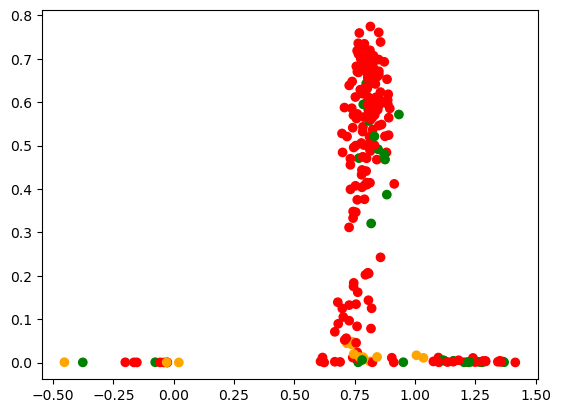

In [46]:
#Using norm_data_init_cl, plot the survace brightness v logarithm of the scale length
import matplotlib.pyplot as plt
#Colour the dots red orange and green based on summary_2
#Append summary 2 to norm_data_init_cl
norm_data_init_cl['summary_broad'] = norm_data_init_cl_final['summary_broad']

norm_data_init_cl_4 = norm_data_init_cl[norm_data_init_cl[' particles type'] == 4]
import numpy as np

#Plot the data log of scale length against brightness - colouring the dots based on the y n m in summary_broad
plt.scatter(np.log10(norm_data_init_cl_4['calculate_scale_length_data']), norm_data_init_cl_4['calculate_surface_brightness_data'],color=norm_data_init_cl_4['summary_broad'].map({'y': 'green', 'm': 'orange', 'n': 'red'}))

In [ ]:
import numpy as np

def calculate_shape_and_sersic(df, particle_type, folder):
    # Get the unique timesteps for the particle type
    timesteps = df[df[' particles type'] == particle_type]['timestep_val'].unique()

    results = []
    for timestep in timesteps:
        df_timestep = df[(df[' particles type'] == particle_type) & (df['timestep_val'] == timestep)].copy()

        # Calculate shape tensor
        shape_tensor = np.zeros((3, 3))
        for i in range(3):
            for j in range(3):
                shape_tensor[i, j] = np.sum(df_timestep[f' {i+1}']**2)

        # Calculate eigenvalues of shape tensor
        eigenvalues, _ = np.linalg.eig(shape_tensor)
        eigenvalues = np.sort(eigenvalues)[::-1]  # Sort eigenvalues in descending order

        # Calculate r_half
        r_half = np.sqrt(eigenvalues[0] * r_half_fraction)

        # Calculate Sérsic index
        sersic_index = fit_sersic_profile(df_timestep, r_half)

        results.append([particle_type, timestep, folder, r_half, sersic_index])

    results_df = pd.DataFrame(results, columns=[' particles type', 'timestep_val', 'folder', 'r_half', 'sersic_index'])
    return results_df

def fit_sersic_profile(df, r_half):
    # Perform the Sérsic profile fitting and return the Sérsic index
    # Add your code here to fit the Sérsic profile using the stellar surface-density profiles
    
    # Dummy calculation for demonstration
    sersic_index = 4.0
    
    return sersic_index


In [ ]:
import numpy as np
from scipy.optimize import curve_fit

def sersic_profile(r, I_e, r_e, n):
    b_n = 1.9992*n - 0.3271  # approximation valid for 0.5 < n < 10
    return I_e * np.exp(-b_n * ((r/r_e)**(1/n) - 1))

def calculate_shape_and_sersic(df, particle_type):
    # Get the unique timesteps for the particle type
    timesteps = df[df[' particles type'] == particle_type]['timestep_val'].unique()

    results = []
    for timestep in timesteps:
        df_timestep = df[(df[' particles type'] == particle_type) & (df['timestep_val'] == timestep)].copy()

        # Calculate the center of the galaxy
        center = [df_timestep['mean_x'].values[0], df_timestep['mean_y'].values[0], df_timestep['mean_z'].values[0]]

        # Calculate the radius of each particle from the center
        df_timestep['radius'] = np.sqrt((df_timestep[' x[kpc]'] - center[0])**2 +
                                        (df_timestep[' y[kpc]'] - center[1])**2 +
                                        (df_timestep[' z[kpc]'] - center[2])**2)

        # You can use a histogram to estimate the number density of particles at different radii
        # (or "intensity" at different radii). However, this would not be a surface brightness, since we're working in 3D.
# Calculate the histogram of the radius values with normalization
        df_timestep['intensity'], bins = np.histogram(df_timestep['radius'], bins=50, density=True)

# Calculate the radius of each bin
        df_timestep['radius_bin'] = 0.5 * (bins[:-1] + bins[1:])

        # Calculate r_half
        total_particles = df_timestep.shape[0]
        cumulative_particles = df_timestep['intensity'].cumsum()
        half_particles_index = np.searchsorted(cumulative_particles, total_particles / 2)
        r_half = df_timestep.iloc[half_particles_index]['radius_bin']

        # Calculate Sérsic index
        sersic_index = fit_sersic_profile(df_timestep, r_half)

        results.append([particle_type, timestep, r_half, sersic_index])

    results_df = pd.DataFrame(results, columns=[' particles type', 'timestep_val', 'r_half', 'sersic_index'])
    return results_df

def fit_sersic_profile(df, r_half):
    # Here we assume that you have columns 'radius_bin' and 'intensity' in your dataframe
    # 'radius_bin' should represent the distance of each particle from the center of the galaxy
    # 'intensity' should represent the intensity (or number density) at that radius
    radii = df['radius_bin']
    intensities = df['intensity']

    # Initial guess for the parameters (I_e, r_e, n)
    guess = (intensities.max(), r_half, 1)

    popt, _ = curve_fit(sersic_profile, radii, intensities, p0=guess)

    return popt[2]  # return the Sérsic index n


In [ ]:
#call the function on df
shape_and_sersic_df = calculate_shape_and_sersic(df, '4')

# Other graphs

In [ ]:
#Looking at the graphs
import os
import datetime
import traceback
# Write a loop that will loop over the folders and build up df_control from the average of 3 simulations

# These are the functions to analyze
functions = [ef.calculate_eccentricity, ef.calculate_relative_density_table, ef.calculate_fwhm_2D, ef.calculate_fwhm_3D, ef.calculate_fwhm_method_1, ef.calculate_half_mass_radius, ef.calculate_scale_length, ef.calculate_surface_brightness, ef.calculate_metrics]

# Snip the folders variable to 5
folders_cut = folders[0:5]

# Initialize an Excel file to write the data to
import datetime
now = datetime.datetime.now()
now = now.strftime("%Y-%m-%d_%H-%M-%S")
# Create the data folder if it doesn't exist
if not os.path.exists('data'):
    os.makedirs('data')

def get_data(start_timestep, end_timestep, particle_types, folders, functions):
    processed_job_numbers = set()
    # read in the excel file 'data_summary' if it exists
    if os.path.exists('data/data_summary.csv'):
        data_summary = pd.read_csv('data/data_summary.csv')
        #add the data_summary column 'folder' to the processed_job_numbers set
        processed_job_numbers = set(data_summary['folder'])
        #else continue as normal
    else:

        pass
    error_folders = []
    for folder in folders:
        try:
            # If the folder name starts with a 1, we want to analyze it
            if folder[0] == '1':
                job_number = folder.split('_')[0]  # Extract job number from folder name

                # Check if job number already exists in the processed job numbers set
                if job_number in processed_job_numbers:
                    continue  # Skip this folder

                # Need to clean the data!!!
                df = ef.adjust_data(ef.read_data(folder))
                df = df[df[' particles type'] != '5']
                df = ef.remove_first_timestep(ef.add_vector_length(df))

                # Initialize the dataframes
                data_raw = pd.DataFrame(columns=[' particles type', 'timestep_val'])
                data_summary = pd.DataFrame(columns=[' particles type', 'timestep_val'])

                # Loop over the functions to pull the data
                for func in functions:
                    data_summary_temp, data_raw_temp = ef.analyse_function_range(func, df, particle_types, start_timestep, end_timestep, folder)
                    # Append the new data to data_summary and data_raw
                    data_summary = data_summary.merge(data_summary_temp, on=[' particles type', 'timestep_val'], how='outer')
                    data_raw = data_raw.merge(data_raw_temp, on=[' particles type', 'timestep_val'], how='outer')

                #Remove all folder_x and all folder_y columns
                data_summary = data_summary.drop(columns=['folder_y'])
                data_summary = data_summary.drop(columns=['folder_x'])
                data_raw = data_raw.drop(columns=['folder_y'])
                data_raw = data_raw.drop(columns=['folder_x'])

                #Remove the job number from the column headers
                data_summary.columns = [col.replace(job_number+'_', '') for col in data_summary.columns]

                # Write data_summary to the CSV file
                with open(f'data/data_summary.csv', 'a') as f_summary:
                    data_summary.to_csv(f_summary, header=f_summary.tell() == 0, index=False)

                # Write data_raw to the CSV file
                with open(f'data/data_raw.csv', 'a') as f_raw:
                    data_raw.to_csv(f_raw, header=f_raw.tell() == 0, index=False)

                # Update the processed job numbers set
                processed_job_numbers.add(job_number)
        except Exception as e:
            error_folders.append(folder)
            print(f"Error occurred in folder: {folder}")
            print(f"Error message: {str(e)}")
            print("Traceback:")
            traceback.print_exc()  # This will print the traceback

    # Print the error folders
    print("Folders with errors:")
    print(error_folders)

# Create the data folder if it doesn't exist
if not os.path.exists('data'):
    os.makedirs('data')

# Get the current timestamp
now = datetime.datetime.now()
now = now.strftime("%Y-%m-%d_%H-%M-%S")

# Run the function to add new data from get_data to the CSV files
get_data(start_timestep, end_timestep, particle_types, folders_cut, functions)


In [ ]:
#pull in the folder 1000 job into data and clean it
df = ef.adjust_data(ef.read_data(1000))
df = df[df[' particles type'] != '5']
df = ef.remove_first_timestep(ef.add_vector_length(df))

ef.quiver_save(df,'4',map,1000)

#Plot galaxy quiver in ef can also be used with make_gif to see how the arrows go over time. There is also a density plotter over time in ef using sns's kde's

In [ ]:
#Plot galaxy quiver in ef can also be used with make_gif to see how the arrows go over time. There is alos a density 